# Optimization for Neural Network Training
## Machine Learing 410
## Stephen Elston


## 1.0 Introduction

Deep neural networks are trained by **learning** a set of weights. The optimal weights are learned by **minimizing the loss function** for the neural network. This minimization is performed using an **optimization algorithm**. Thus, optimization algorithms are an essential component in our neural network tool box.   

In this lesson you will become familar with the basic optimizatiion algorithms used to train deep neural networks and their pitfalls. The nonlinear nature of neural networks leads to several serious problems with local gradients. As a result of the multiple nonlinearities the local gradient can exhibit complex behavior. Further, the local gradient can be quite different from the larger-scale global behavior of the loss function gradient. 

The high dimensionality of the neural network training optimization problems makes detailed understanding of the behavior extreemly difficult. There is one dimension for each model weight (parameter). The optimization is performed over a non-linear surface with millions of dimensions. Dispite several decades of research much of the measureable progress has been based on emperical experience rather than theory.   


****
**Required reading list** from the GBC book:
- 8.0
- 8.1
- 8.1.1
- 8.1.3
- 8.2
- 8.2.1
- 8.2.2
- 8.2.3
- 8.2.4
- 8.2.5
- 8.2.7
- 8.2.8
- 8.3
- 8.3.1
- 8.3.2
- 8.4
- 8.5
- 8.5.1
- 8.5.2 
- 8.5.3
- 8.5.4


### 1.1 Local convergence of optimization algorithms

In an idea case, an minimization problem is **convex**. By convex, we mean that the graidient always points in the direction of the **global minimum** of the loss function. Unfortunately, with nonlinear optimizaion problems, like neural network training, there is no gauarantee that the minimization problem is convex. Further the loss function can have multiple **local minimum**. 

Keeping the foregoing in mind, the minimization of the loss function will at least be convex locally around any minimum. To understand the behavior of a loss function around a minimum we can expand it as a second order Taylor series of the change in the weights from optimization step $l$ to $l+1$:

$$J(\vec{w}^{(l+1)}) = J(\vec{w}^{(l)}) + (\vec{w}^{(l+1)} - \vec{w}^{(i)})\vec{g} + \frac{1}{2}(\vec{w}^{(l+1)} - \vec{w}^{(i)})^T H (\vec{w}^{(l+1)} - \vec{w}^{(i)}) $$

where,   
$\vec{w}^{(l)}$ is the vector of weights at step $l$,  
$\vec{g}$ is the gradient vector,  
$H$ is the **Hessian** matrix. 

The Hessian is a matrix of second partial derivatives. You can think of the Hessian as being the rate of change of the gradient or the gradient of the gradient. For a vector gradiemt $f(\vec{x})$ the Hessian is:

$$H f(\vec{x}) = \begin{bmatrix}
  \frac{\partial f(\vec{x})}{\partial x^2_1} & 
  \frac{\partial f(\vec{x})}{\partial x_2 \partial x_1} & 
  \cdots & 
  \frac{\partial f(\vec{x})}{\partial x_n \partial x_1}\\
   \frac{\partial f(\vec{x})}{\partial x_1 \partial x_2} &
   \frac{\partial f(\vec{x})}{\partial x^2_2} & 
   \cdots &
   \frac{\partial f(\vec{x})}{\partial x_1 \partial x_n}\\
   \vdots & \vdots & \vdots & \vdots \\
   \frac{\partial f(\vec{x})}{\partial x_1 \partial x_n} &
   \frac{\partial f(\vec{x})}{\partial x_2 \partial x_n} & 
   \cdots &
   \frac{\partial f(\vec{x})}{\partial x^2_n} 
 \end{bmatrix}$$
 
The Hessian has severl useful properties. 

- The Hessian is symmetric, since $\frac{\partial f(\vec{x})}{\partial x_1 \partial x_2} = \frac{\partial f(\vec{x})}{\partial x_2 \partial x_1}$.
- If the eigenvalues of the Hessian are all possitive, the crvature of the gradient is upward, indicating and minimum point in $f(\vec{x})$. The optimization is convex, at least locally. In this case we say the Hessian is **positive definite**.
- If the eigenvalues of the Hessian are all negative, the crvature of the gradient is downward, indicating and maximum point in $f(\vec{x})$. In this case we say the Hessian is **negative definite**.
- A Hessian with mixed sign eigenvalues indicates gradient with upward curvature in some dimensions and downward curvature in other dimensions. This situation with mixed cuvature is known as a **saddle point**. 
- For a Gaussian process the Hessian is the inverse of the covariance matrix. The eigenvalues of each matrix are just the inverse of the other. 

For a step size $\epsilon$ we can rewrite the first equation as:

$$J(\vec{w}^{(l)}- \epsilon \vec{g}) = J(\vec{w}^{(l)}) - \epsilon \vec{g}^T \vec{g} + \frac{1}{2} \epsilon^2 \vec{g}^T H \vec{g}$$

The minimum point of $J(\vec{w}^{(l)}- \epsilon \vec{g})$ ocurrs were the gradient is zero in all dimensions. This is evident from the fact that at this point:
$$J(\vec{w}^{(l)}) = J(\vec{w}^{(l)}- \epsilon \vec{g})$$ 

From this point no further reduction in the loss function is possible. The optimal step size for the quadradic approximation is then: 

$$\epsilon^* = \frac{\vec{g}^T \vec{g}}{\vec{g}^T H \vec{g}}$$

But, what happens if the Hessian is not well behaived? One measure of 'behavior' for a Hessian is the **condition number**:

$$\kappa(H) = \frac{|\lambda_{max}(H)|}{|\lambda_{min}(H)|}$$

where,  
$|\lambda_{max}(H)|$ is the absolute value of the largest eigenvalue of H.  
$|\lambda_{min}(H)|$ is the absolute value of the smallest eigenvalue of H.   

The condition number of the Hessian has serious implications for the rate of convergence of optimization algorithms. If the condition number is small, the Hessian is well conditioned and the gradient have similar scale in all dimensions. An ideal condition number is close to 1. 

However, if the Hessian is **ill-conditioned**, having a large condition number, the scale of the gradient will be quite different in different dimensions. An optimization algorithm will converge quickly along eiginvector directions corresponding to large eigenvalues. However, convergece will be slow along the direction of eigenvectors with small corresponding eigenvalues. This situation has been describe as slowly meandering down a long narrow valley. In fact, for real-world stochastic problems (e.g. noisy data), the optimization algorithm may not converge at all along some eigenvector directions!

### 1.2 Multimodal loss function and global optimization

The nonlinear nature of the hidden layers can lead to loss functions with significant local structure in a high dimensional space. Given this complexity, it is quite possible there are local minimum, local maximum, or saddle points. In general, there is no guarantee that the global minimum of the objective function can ever be found.     

In the early days of neural network research it was generally thought that loss function minimization got 'stuck' at local minimum or saddle points. However, recent experience indicates that this may not be the case. In many real-world cases, the training loss function continues to decrease with epochs. If the optimization algorithm were stuck, this could not be the case. We have explored this behavior in previous lessons.    

Continued convergence of the optimization process does not mean that convergence will be rapid. Emperical experience indicates that slow convergence is a common problem. This situation occurs when the Hessian of the loss function is ill-conditioned. 

### 1.3 Vanishing and exploding gradients

One of the common malities of deep neural network loss functions are **vanishing gradients** and **exploding gradients**. Vanishing gradients arise when multiple small gradients are encountered in backpropagation. Exploding gradients arise when rapid changes, sometimes referred to as **cliffs**, occur in the loss function are encountered.   

A deep linear model analogy can aid in understanding of vanishing gradients. In this simple model each layer has the same weights $W$. We can compute an eigenvalue-eigenvector decomposition of $W$:

$$W = Q \Lambda Q^T$$   
where,   
$Q$ is the unitary eigenvector matrix,   
$\Lambda$ is the diagonal matrix of eigenvalues. 

At the nth layer a signal entering the top of the network will be weighted by $W^n$ which we can write:

$$W = \big( Q \Lambda Q^T \big)^n = Q \Lambda^n Q^T$$

In order to have a stable network all the eigenvalues must be less than 1. Therefore $\Lambda^T$ is a diagonal matrix of increasingly small numbers as $n$ increases. The net effect is that gradients from deep in the networks can be exponentially smaller than from shallow layers. When the backpropagation is applied, the gradient effectively vanises toward 0. 

Exploding graidents arrise from sudden changes in curvature of the loss function. Encountering these 'cliffs' results in a gradient decent algorithm overshooting the minimum point, sometimes by an extreem amount. The Hessian represents the curvature of the loss function or the rate of change of the gradient. The eigendecomposition of the Hessian:

$$H(J(W)) = Q \Lambda Q^T = Q diag(\lambda) Q^T$$

Consider what happens when the loss function has high local curvature. At one optimization step, the eigenvalues $diag(\lambda)$ are all small and well behaived. The Hessian has a small condition number. At the next step the eigenvalues can become enourmous (much greater than 1), since the curvature of the loss function is changing so rapidly. Since only some eigenvalues grow large, the condition number becomes extreemly large.  This leads to the eploding gradient! 

Fortunately, there is a simple solution the exploding gradient problem, **gradient clipping**. As the name implies, gradient clipping is nothing more than imposing a hard maximum constraint on the gradient. In practice, this simple algorithm have proven to be quite effective. 

***
**Note:** All optimizers in Keras have parameters to clip individual weights or the norm of the gradient. 
***

### 1.4 Flat spots

With complex loss function it is common to have regions that are **flat**. These reasons are often called **plateaus**. That is with negligible gradient. These regions can result in extremely low learning. There are a number of solutions for this problems. The learning rate can be increased or momentum can be used. These approaches are discussed later in this lesson. 

****
**Note:** Keras has a callback that can be used to take action when slow learning is encountered.  
****

## 2.0 Batch gradient decent for backpropagation

Recall, that we train neural networks using the **backpropagation** algorithm. The backpropagation algorithm requires several components:

1. A **loss function** to measure how well our representation matches the function we are trying to learn. S
2. A method to propagate changes in the represenatuion (weights) through the complex network For this we will use the **chain rule of calculus** to compute **gradients** of the represenation. In the general case, this process requires using automatic differentiation methods. 
3. An **optimization algorithm** that uses the gradients to minimize the loss function.  

The backpropagration algorithm learns the optimal weights for the neural network by taking small steps in the direction of the **local gradient**. By *local gradient* we mean the gradient of $J(W)$ computed at each set of weights $W$ as the algorithm proceeds. 

Once we have the gradient of the loss function we can update the tensor of weights using the formulation below.

$$W_{t+1} = W_t + \alpha \nabla_{W} J(W_t) $$  
where  
$W_t = $ the tensor of weights or model parameters at step $t$.   
$\alpha\ = $ step size or learning rate.  
$J(W) = $ loss function given the weights.  
$\nabla_{W} J(W) = $ gradient of $J$ with respect to the weights $W$.  

It should be evident that the back propagation algorithm is a form of gradient decent. The weights are updated in small steps following the local gradient of $J(W)$ down hill. At the **termination condition** $J(W)$ should be at or very near the minimum possible value. 



### 2.1 Compuational example

The basic idea is simple, but actually optimizing a complex neural network is another mater altogether. To demonstrate the concept, we will work on a very simple 2-d problem. The loss function in this case is the mean square error (MSE). So, in effect, the minimim MSE is the same as the maximum likelihood (MLE) solution. 

The loss function for a Gaussian process is:

$$J(\hat{x}) = \frac{1}{N} \sum_{i = 1}^{N} \big( \vec{x}_i - \hat{x} \big)^2$$  

where;  
$x = $ the sample data, which is a 2d tensor in this case of dimension $N x 2$ where $N$ is the number of samples,    
$\hat{x} = $ the vector of means we want to estimate.  

We can compute the gradient for each dimension of as follows:

$$\frac{ \partial \hat{x}}{ \partial x_j} = \frac{2}{N} \sum_{i = 1}^{N} \big(  x_{ij} - \tilde{x}_j \big)$$  

where,  
$x_j = $ the jth dimension of $\vec{x}$,   
$x_{ij} = $ the ith component of the jth dimension of $\vec{x}$,   
$\tilde{x}_i = $ is the current estimate of ith component of $\hat{x}$. 


Execute the code in the cell below to load the packages required to execute the rest of this notebook. 

In [2]:
import keras
from keras.datasets import mnist
import keras.utils.np_utils as ku
import keras.models as models
import keras.layers as layers
from keras import regularizers
from keras.layers import Dropout
from keras import optimizers
import numpy as np
import numpy.random as nr
import numpy.linalg as nll
import sklearn.model_selection as ms
import time
import matplotlib.pyplot as plt
import math

%matplotlib inline

The code in the cell below simulates a bivariate Normal distribution with high covariance between the two dimensions. Execute this code.

In [3]:
cov = np.array([[1.0, 0.99], [0.99, 1.0]])
mean = np.array([1.0, 2.0])

sample = nr.multivariate_normal(mean, cov, 500)
sample.shape

(500, 2)

As already mentioned, for a Gaussian process, the covariance matrix is the inverse the Hessian> This means that both matricies have the same condition number. The code in the cell below computes and displays the eigenvalues of the covariance matrix and the condition number. Execute this code and examine the result. 

In [4]:
eigenvalues = nll.eig(cov)[0]
print('Eigenvalues = ' + str(eigenvalues))
print('The condition number = ' + str(eigenvalues[0]/eigenvalues[1]))

Eigenvalues = [ 1.99  0.01]
The condition number = 199.0


The covarience matrix has a high condition number. This optimization problem will deliberately strain the algorithms. 

****
**Note:** In a real-world problem, the condition number can be improved by simple Z-Score scaling. However, for the purpose of demonstration we will skip this step. 
****

Next, exectute the code in the cell below to plot the simulated data and examine the result. 

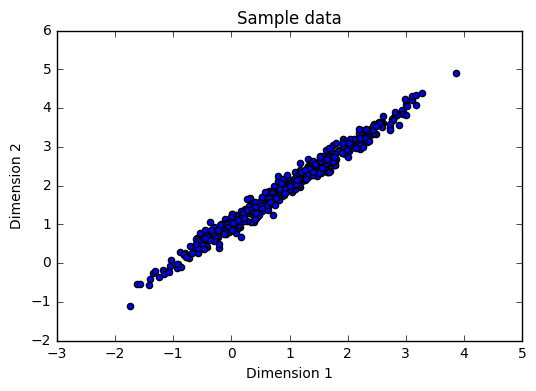

In [5]:
plt.scatter(sample[:,0], sample[:,1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Sample data')

With the simulated data prepared, it is time to try gradient decent! The code in the cell below implements a basic **batch gradient decent** algorithm. This algorithm is considered batch gradient decent since all of the cases are used to compute each update of the gradient. 

The work is done in the `while` loop. The termination condition is the l2 norm of the gradient is less than a set value or the maximum number of iterations has been executed. The learning rate is fixed for each optimization step. An array is output at the end that gives the path history of the optimizer. 

Execute this code and examine the result. 

In [6]:
def compute_gradient(x, estimate):
    mult = 2.0/x.shape[0]
    diff = np.subtract(x, estimate)    
    return mult * np.sum(diff, axis = 0)

def grad_decent(x, estimate, lr, stopping, max_its = 100):
    out = estimate
    out = out.reshape((1,2))
    err = 10000000.0 ## starting criteria for graident metric
    i = 1
    while(err > stopping and i < max_its):
        grad = compute_gradient(x, estimate)
        estimate = estimate + lr * grad
        out = np.append(out, estimate.reshape((1,2)))
        err = np.std(grad)
        i = i + 1
    out = out.reshape((i, 2))    
    print('Number of iterations = ' + str(i))   
    print('Final gradient value = ' + str(np.std(grad)))
    print('MLE = ' + str(out[i-1:]))
    return out

lr = 0.1
stopping = 0.01
#start = np.array([5.0,-1.0])
start = np.array([0.0,0.0])
steps = grad_decent(sample, start, lr, stopping)

Number of iterations = 23
Final gradient value = 0.00918466861447
MLE = [[ 0.9258999   1.91435594]]


The optimizer appears to have converged to reasonable values in a small number of steps. The MLE can be compared to the location values used in the simulation, $1.0, 2.0 $.

Next execute the code in the cell below to visualize the trajectory taken by the optimizer. 

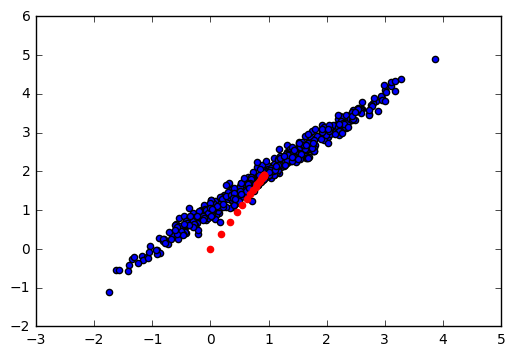

In [7]:
def plot_decent(x, steps):
    plt.scatter(x[:,0], x[:,1])
    plt.scatter(steps[:,0], steps[:,1], color = 'red')

plot_decent(sample, steps)    

The path of convergence looks good. You can see that the rate of convergence of each optimization step decreases as the algorithm approaches convergence. This is expected, since the gradient is decreasing as the optimizer converges.   

## 3.0 Stochastic gradient decent

The **stochastic gradient decent (SGD)** algorithm (Nemirovshi and Yudin, 1978) is the workhorse of deep neural network training. As opposed to batch gradient decent, SGD computes the expected gradient using a **mini-batch** Bernoulli sampled from the full set of cases. Mini-batch optimization is often referred to as **online optimization** since the optimizer algorithm can operate as cases arrive. 

The basic idea of stocastic optimization is that a sample of the data is used to estimate the **expected value** of the weights. The weight update for SGD then becomes:

$$W_{t+1} = W_t + \alpha\ E_{\hat{p}data}\Big[ \nabla_{W} J(W_t) \Big]$$ 

where,  
$E_{\hat{p}data} \big[ \big]$ is the expected value of the gradient given the Bernoulli sample of the data $\hat{p}data$.

Since the SGD algorithm works on mini-batches, it is highly scalable when compaired to the batch gradient decent. The later must keep all cases in memory.  

Choosing batch size can require some  tuning. If the batch is too small, the gradient estimate will be poor. Further, hardware resources will not be fully utilized. Large batches require significant memory. Further, large batches can slow down the compuation of each gradient step.  

Emperically, SGD has good convrgence properties. This may be from the fact that the mini-batch samples alow a better exploration of the loss function space. In fact, for very large datasets the following sampling often converges before the first pass through the data is completed:f

`Random_sort(cases)
while(grad > stopping_criteria):
    mini-batch = sample_next_n(cases)
    grad = compute_expected_grad(mini_batch)
    weights = update_weights(weights, grad)`
    
Notice that if the sampling continues for more than one cycle through the cases, the samples are biased. In practice, this small bias does not seem to mater much.     

### 3.1 Example of basic SGD

The code in the cell below implements a basic SGD algorithm. The code is nearly identical to the batch gradient decent function. The only difference is the the Bernoulli sampling using `numpy.random.choice`.

Execute this code and examine the result. 

In [8]:
def sgd(x, estimate, lr, stopping, batch_size = 8, max_its = 100):
    out = estimate
    out = out.reshape((1,2))
    err = 10000000.0 #
    # starting criteria for graident metric
    i = 1
    indx = range(x.shape[0])
    while((err > stopping) and (i < max_its)):
        sample_idx = nr.choice(indx, batch_size)
        grad = compute_gradient(x[sample_idx,:], estimate)
        estimate = estimate + lr * grad
        out = np.append(out, estimate.reshape((1,2)))
        err = np.std(grad)
        i = i + 1
    out = out.reshape((i, 2))    
    print('Number of iterations = ' + str(i))   
    print('Final gradient value = ' + str(np.std(grad)))
    print('MLE = ' + str(out[i-1:]))
    return out

lr = 0.1
stopping = 0.01
#start = np.array([5.0,-1.0])
start = np.array([0.0,0.0])
steps = sgd(sample, start, lr, stopping)

Number of iterations = 15
Final gradient value = 0.00276877414937
MLE = [[ 0.93862212  1.90015802]]


The SGD algorithm converges to nearly the same result in a similar number of steps as the batch gradient decent algorithm. Using mini-batches has not chnged the result significantly.  

Next, exectue the code in the cell below to visualize the optimization trajectory.  

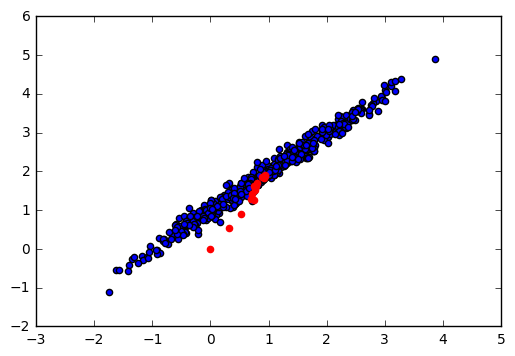

In [9]:
plot_decent(sample, steps)   

Compare the trajectory of the SGD optimizer to the batch gradient decent optimizer. In appears that th SGD optimizer converges faster initally, but then seems to wander a bit near convergance. this makes sense, since the expected gradient from the small mini-batches is likely to be noisier than the batch gradient. 

### 3.2 Adding momentum to SGD

With poorly conditioned loss functions, SGD is known to 'zig-zag' back and forth as the optimizer moves toward convergence. This problem can be severe in some case, leading to many wasted optimization step that provide only minimal reduction in the loss function at best. To overcome this problem, in  1988 paper Rummelhart, et. al., proposed adding a **momentum** term to the gradient update. 

Recall from Newtonian mechanics that $momentum = m \cdot v$, where $m$ is the mass and $v$ is the velocity. If we assume that $m = 1$ then momentum is the same as velocity. The model weight update then becomes a weighted sum of velocity (momentum) and the gradient:

$$v^{(l)} = momuntum \cdot v^{(l - 1)} + lr \cdot \nabla_{W} J(W^{(l)})\\
W^{(l+1)} = W^{(l)} + v^{(l)}$$   
where,   
$v^{(l)}$ is the velocity at step $l$,    
$momentum$ is the momentum multiplier,    
$lr$ is the learning rate.   

The code in the cell below implements a basic versison of the SGD algorithm with momentum. The algorithm is identical to ordinary SGD except the update of the weight estimate. 

Execute this code and examine the result.

In [12]:
def sgd_momentum(x, estimate, lr, stopping, momentum, batch_size = 8, max_its = 100):
    out = estimate
    out = out.reshape((1,2))
    v = np.zeros((1, x.shape[1]))
    err = 10000000.0 ## starting criteria for graident metric
    i = 1
    indx = range(x.shape[0])
    while((err > stopping) and (i < max_its)):
        sample_idx = nr.choice(indx, batch_size)
        grad = compute_gradient(x[sample_idx,:], estimate)
        v = momentum * v + lr * grad
        estimate = estimate + v
        out = np.append(out, estimate.reshape((1,2)))
        err = np.std(grad)
        i = i + 1
    out = out.reshape((i, 2))    
    print('Number of iterations = ' + str(i))   
    print('Final gradient value = ' + str(np.std(grad)))
    print('MLE = ' + str(out[i-1:]))
    return out

lr = 0.1
stopping = 0.01
#start = np.array([5.0,-1.0])
start = np.array([0.0,0.0])
momentum = 0.1
steps = sgd_momentum(sample, start, lr, stopping, momentum)

Number of iterations = 13
Final gradient value = 0.0028147344585
MLE = [[ 1.02851782  1.98410207]]


These results are nearly identical to those obtained for the basic SGD algorithm. Given the convex nature of the problem, this is not teribly surprising. 

Now, execute the code below to display and examine the trajectory of the optimization algorithm.

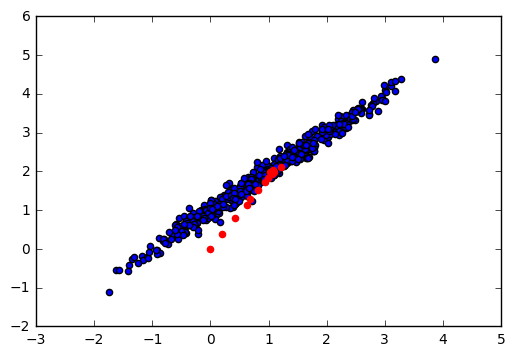

In [13]:
plot_decent(sample, steps)  

This result is largely the same as for the basic SGD algorithm. 

### 3.3 SGD with Keras

Keras has an extensive library of optimizers, including a full-featured SGD method. The Keras website has somewhat sparse [documentation on the available optimizers](https://keras.io/optimizers/).

As a first step before trying out the Keras SGD optimizer we need to create test and training data set in the form of numpy arrays. Execute the code in the cell below that does just this. 

In [14]:
indx = range(sample.shape[0])
nr.seed(9988)
indx = ms.train_test_split(indx, test_size = 100)
x_train = np.ravel(sample[indx[0],[0]])
y_train = np.ravel(sample[indx[0],[0]])
x_test = np.ravel(sample[indx[1],[1]])
y_test = np.ravel(sample[indx[1],[1]])

With the data prepared with can get to work with training and testing the neural network model with the SGD optimizer. 

To create a problem where a neural network can be applied, we will solve the regression problem for the simulated data we have been suing. 

The SGD optimizer in Keras has a number of arguments including for: 
- learning rate: `lr`, 
- gradient clipping: `clipnorm`,
- decay rate: `decay`, 
- momentum: `momentum`. 

Examine the code below for details. Execute the code and examine the results. 

Execution time = 2.178494691848755


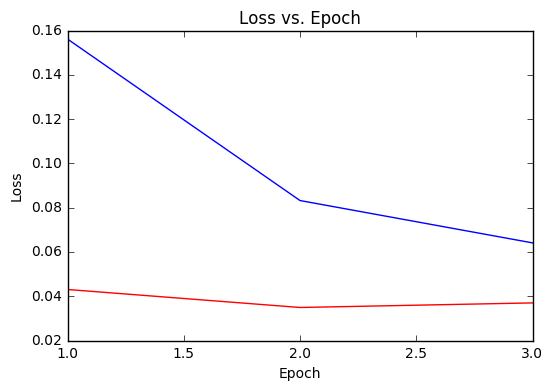

In [15]:
def plot_loss(history):
    '''Function to plot the loss vs. epoch'''
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red')
    plt.plot(x, train_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')


## First define the layers of the regression model. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (1, ),
                        kernel_regularizer=regularizers.l2(0.01)))
nn.add(Dropout(0.5))
nn.add(layers.Dense(1))

## Define the SGD optimizer
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=False)
## The optimizer is used at the compile stage
nn.compile(optimizer = sgd, loss = 'mse', metrics = ['mae'])

## Define the callback list
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use accuracy to monitor the model
        patience = 1 # Stop after one step with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]

## Now fit the model
start = time.time() ## Get the system time at strat of execution
history = nn.fit(x_train, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)
end = time.time() ## Get the system time at the end of execution
## Execution time is the difference between the end and start times
print('Execution time = ' + str(end - start))

## Visualize the outcome
plot_loss(history)

Notice that training loss continues to decrease even after test loss increases. This is a key porperty of how optimizers behave for learning in neural networks. 

We should check that the learned model actually makes sense. The code in the cell below predicts score values for the test dataset, prints the RMSE and plots the result. Execute this code and examine the outcome. 

1.50070354169


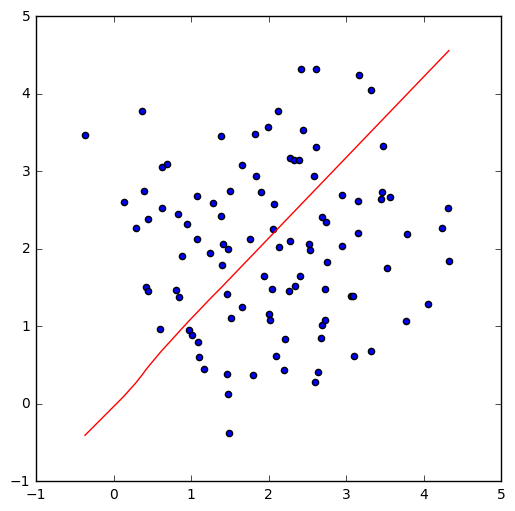

In [16]:
def plot_reg(x, y_score, y):
    ax = plt.figure(figsize=(6, 6)).gca() # define axis
    
    ## Get the data in plot order
    xy = sorted(zip(x,y_score))
    x = [x for x, _ in xy]
    y_score = [y for _, y in xy]

    ## Plot the result
    plt.plot(x, y_score, c = 'red')
    plt.scatter(x, y)


predicted = nn.predict(x_test)
plot_reg(x_test, predicted, y_test)
print(np.std(predicted - y_test))

These results seem reasonable given the data. 

## 4.0 Adaptive gradient decent algorithms

Up until now, we have been worked with algorithms with constant learning rates. In many cases, the gadient of the loss function will change multiple times before convergance is achieved. For eample, the gradient may decrese and then increse again. In these cases, a constant learning rate results in slow convergence. There are several possible approaches to changing learning rates of optimization algorithms. 

One simple approach is use **learning rate decay**. The learning rate decays from a starting value and decreases as the optimization proceeds. This approach is effective in cases where the gradient decreases fairly steadily as the optimization proceeds. The lower learning rate reduces the chance that the algorithm over-shoots the optimum point and then wanders around with slow convergence. We have sceen this behavior in the foregoing SGD examples.    

The second approach is to use algorithms with an **adaptive learning rate**. As the name implies, adaptive learning rate algorithms change their rate of convergence depending on the gradient. Ideally, if the learning rate should increase when plateaus and poorly conditioned areas of the loss function are encountered. The learning rate should decrease when the gradient of the loss function is better behaived. In practice, these ideals are hard to achieve and researchers have created many algorithms using various huristics to adapt learning rate. 

### 4.1 An example of adaptive learning, Adam

The Adam algorithm (Kingma and Ba, 2014) uses a fairly complicated set of huristics adapt the learning rate. Adam uses both first and second order momentum measures. Second order momentum is analogous to kinetic energy in Newtonian mechanics. Further, Adam encorporates exponential decay in both momentum measures to ensure that more recent values dominate the learning rate updates. 

The code in the cell below implements a basic version of Adam. Examine this code for details, execute this code and check the results.

In [19]:
def adam(x, estimate, lr, stopping, momentum, ke, batch_size = 32, max_its = 1000):
    out = estimate
    out = out.reshape((1,2))
    s = np.zeros((1, x.shape[1]))
    r = np.zeros((1, x.shape[1]))
    grad_norm = 10000000.0 ## starting criteria for graident metric
    i = 1
    indx = range(x.shape[0])
    while((grad_norm > stopping) and (i < max_its)):
        sample_idx = nr.choice(indx, batch_size)
        grad = compute_gradient(x[sample_idx,:], estimate)
        s = momentum * s + (momentum - 1.0) * grad
        s_tilde = s/(1 - momentum**i)
        r = ke * r + (ke - 1.0) * np.multiply(grad, grad)
        r_tilde = np.sqrt(np.abs(r/(1 - ke**i)))
        delta = np.array([lr* ss/(rr + 0.000001) for ss, rr in zip(s_tilde, r_tilde)])
        estimate = estimate - delta 
        out = np.append(out, estimate.reshape((1,2)))
        grad_norm = np.std(grad) 
        i = i + 1
    out = out.reshape((i, 2))    
    print('Number of iterations = ' + str(i))   
    print('Final gradient value = ' + str(np.std(grad)))
    print('MLE = ' + str(out[i-1:]))
    return out

lr = 0.1
stopping = 0.01
#start = np.array([5.0,-1.0])
start = np.array([0.0,0.0])
momentum = 0.1
ke = 0.1
steps = adam(sample, start, lr, stopping, momentum, ke)

Number of iterations = 22
Final gradient value = 0.0012659526011
MLE = [[ 0.7878036  1.7443972]]


These results are not too different from the SGD algorithms. 

Now, exectute the code below and examine the results.

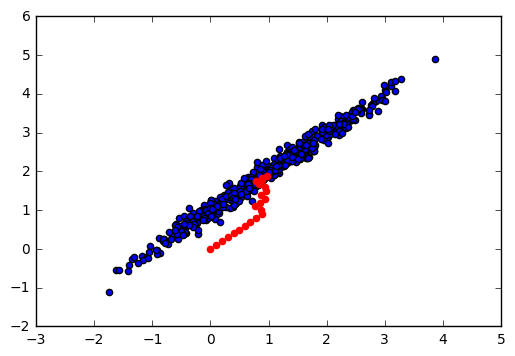

In [20]:
plot_decent(sample, steps)  

The trajectory of the Adam optimizer is considerably different than SGD. Notice how the trajectory 'zig-zags' toward convergence. This is likely the result of the poor conditioning of the problem. 

### 4.2 Adaptive optimization with Keras

Now, let's try adaptive optimization with Keras. We will use one of the mostly widely used adaptive algorithms, RMSprop (Hinton, 2012). Like Adam, RMSprop accumulates a measure of the squared gradient to change the learning rate. An exponential decay is applied to the accumulated squared gradient to ensure that more recent experience dominates the learning rate. 

Examine the code below for details. Excute the code and examine the results. 

Execution time = 1.7370762825012207


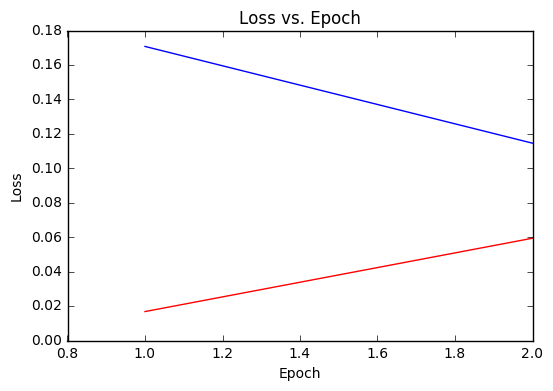

In [21]:
## First define the regression model. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (1, ),
                        kernel_regularizer=regularizers.l2(0.01)))
nn.add(Dropout(0.5))
nn.add(layers.Dense(1))

## Define the RMS optimizer
RMS = optimizers.RMSprop(lr=0.01)
nn.compile(optimizer = RMS, loss = 'mse', metrics = ['mae'])

## Now fit the model
start = time.time() # The time as execution start
history = nn.fit(x_train, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)
end = time.time() # Time at execution endf
print('Execution time = ' + str(end - start))

## Visualize the outcome
plot_loss(history)

Notice that RMSprop converges in fewer epochs than SGD for this situation. 

Once again, we should check that the learned model actually makes sense. The code in the cell below predicts score values for the test dataset, prints the RMSE and plots the result. Execute this code and examine the outcome. 

1.34751076735


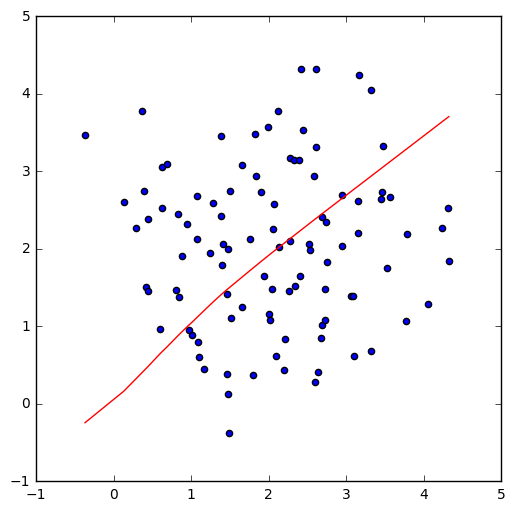

In [22]:
predicted = nn.predict(x_test)
plot_reg(x_test, predicted, y_test)
print(np.std(predicted - y_test))

This result is similar to the one achieved with SGD, but perhaps a bit better and faster. 

## 5.0 Weight initial values

When training deep neural networks the initial values chosen for the weights can have a significant effect on the results. If weights are all set to the same initial value several possible problems will arrise:
- Some of the weights may be linerly dependent. In this case, the weights will change together durring training and not be correctly learned. 
- Some weights will become **stuck** at the initial value and are never learned. This is special case of the first problem, for the most part. 

Fortunatly, the solution to this problem is simple; **randomize** the starting values of the weights.  This process is sometimes referred to as adding **fuzz** to the inital weights. A number of schemes have been tried. For example, initial weight values can be drawn from a Gaussian or Normall distribution. In paractice drawing the initial values from a Uniform distribution works as well as any other scheme.    

#### Copyright 2018, Stephen  F Elston. All rights reserved. 